In [82]:
import os
import sys
import pickle

sys.path.append(os.path.abspath(os.path.join("../../..")))

import numpy as np
import tensorflow as tf
import torch

import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvariantNetwork, InvertibleNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

from hnn_core import jones_2009_model, simulate_dipole, read_params

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf
from bayesflow import computational_utilities as utils

matplotlib.rcParams["figure.dpi"] = 72

from hnn_core.utils import smooth_waveform

In [83]:
RNG = np.random.default_rng(2022)

In [84]:
def prior():
    random_array1 = np.random.uniform(0, 1, size=(1,))
    random_array2 = np.random.uniform(0, 1, size=(1,))
    random_array3 = np.random.uniform(0, 1, size=(1,))
    combined_array = np.vstack((random_array1, random_array2, random_array3))
    combined_array = np.squeeze(combined_array)
    return combined_array

In [85]:
net = jones_2009_model()

In [86]:
def simulator(params, n_obs=1):
    
    avg = 0.004647741
    maxAbs = 0.073834606
    
    res = np.empty((n_obs, 341))
    
    for i in range(n_obs):
        if n_obs==1:
            param0 = params[0]
            param1 = params[1]
            param2 = params[2]
        else:    
            param0 = params[0][i]
            param1 = params[1][i]
            param2 = params[2][i]
        
        net_sim = jones_2009_model()
    
    
        # add a distal evoked drive
        weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': .000007,
                           'L5_pyramidal': param0}
        weights_nmda_d1 = {'L2_basket': 0.019482, 'L2_pyramidal': 0.004317,
                           'L5_pyramidal': 0.080074}
        synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                              'L5_pyramidal': 0.1}
        net_sim.add_evoked_drive(
            'evdist1', mu=63.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
            weights_nmda=weights_nmda_d1, location='distal',
            synaptic_delays=synaptic_delays_d1, event_seed=274)


        # add two proximal drives
        weights_ampa_p1 = {'L2_basket': 0.08831, 'L2_pyramidal': 0.01525,
                           'L5_basket': 0.19934, 'L5_pyramidal': param1}
        synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                                'L5_basket': 1., 'L5_pyramidal': 1.}
        # all NMDA weights are zero; pass None explicitly
        net_sim.add_evoked_drive(
            'evprox1', mu=26.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
            weights_nmda=None, location='proximal',
            synaptic_delays=synaptic_delays_prox, event_seed=544)

        # Second proximal evoked drive. NB: only AMPA weights differ from first
        weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
                           'L5_basket': 0.008958, 'L5_pyramidal': param2}
        # all NMDA weights are zero; omit weights_nmda (defaults to None)
        net_sim.add_evoked_drive(
            'evprox2', mu=137.12, sigma=8.33, numspikes=1,
            weights_ampa=weights_ampa_p2, location='proximal',
            synaptic_delays=synaptic_delays_prox, event_seed=814)

        dpl = simulate_dipole(net_sim, dt=0.5, tstop=170)
        
        
        # v3: Center time series by taking the “grand mean” (mean of all entries in matrix) and subtract from each row
        temp = dpl[0].data['agg']
#         avg = np.mean(temp)
        temp = temp-avg
        
        # v4: Divide entire matrix by maximum of absolute value
#         maxAbs = np.max(np.abs(temp))
        temp = temp / maxAbs
        
#         # v5: smoothing 
        temp = smooth_waveform(temp, window_len=30, sfreq=1000.0 / 0.5)
        res[i] = temp
        

        
#         res[i] = dpl[0].copy().scale(3000).data['agg']
#         res[i] = dpl[0].copy().smooth(30).scale(3000).data['agg']
        

    # print(res.shape)
    return res

In [87]:
generative_model = bf.simulation.GenerativeModel(
    prior=prior, simulator=simulator, name="Generative Model: Training", simulator_is_batched=False
)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...


INFO:root:Performing 2 pilot runs with the Generative Model: Training model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 341)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


In [88]:
summary_net = bf.networks.DeepSet(summary_dim=3)
inference_net = bf.networks.InvertibleNetwork(num_params=3, num_coupling_layers=3)
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, summary_loss_fun="MMD")
trainer = bf.trainers.Trainer(generative_model=generative_model, amortizer=amortizer)

INFO:root:Performing a consistency check with provided components...


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...


INFO:root:Done.


Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


In [89]:
x = torch.load('Aug15_data1000_3ERPDrives_no_preprocessing/x.pt')
theta = torch.load('Aug15_data1000_3ERPDrives_no_preprocessing/theta.pt')

In [90]:
x = np.array(x)
theta = np.array(theta)

In [91]:
x.shape

(1000, 341)

In [92]:
# Center time series by taking the “grand mean” (mean of all entries in matrix) and subtract from each row
avg = np.mean(x)
x = x - avg

# Divide entire matrix by maximum of absolute value
maxAbs = np.max(np.abs(x))
x = x / maxAbs

# # Smoothing
for i in range(len(x)):
    x[i] = smooth_waveform(x[i], window_len=30, sfreq=1000.0 / 0.5)

In [93]:
avg

0.004647741

In [94]:
maxAbs

0.073834606

In [95]:
x.shape

(1000, 341)

In [96]:
theta.shape

(1000, 3)

In [97]:
# Create dictionary that will be saved as a pickle file
presim_dict = dict.fromkeys(['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws',
                             'sim_non_batchable_context', 'sim_batchable_context', 'sim_data'])

# Your parallel simulated data here
x_shape = x.shape
presim_dict['sim_data'] = x.reshape(x_shape[0], 1, x_shape[1])
presim_dict['prior_draws'] = theta
presim_dict = [presim_dict] # for some reason, the pickled file needs to be a list


# Save the dictionary as a pickle file, need to create folder called 'parallel_sim' first
with open('parallel_sim/presim_file_1.pkl', 'wb') as f:
    pickle.dump(presim_dict, f)

In [98]:
losses = trainer.train_from_presimulation(presimulation_path='parallel_sim/', optimizer=tf.keras.optimizers.Adam())

Training epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

In [99]:
losses

,Loss,W.Decay
0,8.625475,0.821717


## set reference_data

In [100]:
shape = x.shape
x = x.reshape(shape[0], 1, shape[1])
x.shape

(1000, 1, 341)

In [101]:
reference_data = {}
reference_data['summary_conditions'] = x
reference_data['direct_conditions'] = None
reference_data['parameters'] = theta

## One Actual HNN simulation output (this should not be mispecified)

In [102]:
data_HNN = simulator(params=(0.142300 , 0.00865, 0.684013))

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...


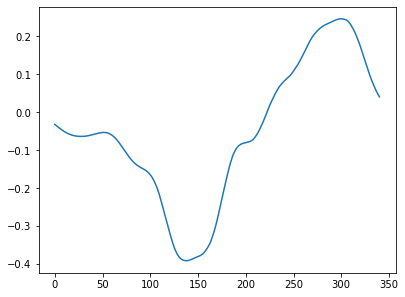

In [103]:
plt.plot(data_HNN.flatten().T)
plt.show()

In [104]:
shape = data_HNN.shape
data_HNN = data_HNN.reshape(shape[0], 1, shape[1])
data_HNN.shape

(1, 1, 341)

In [105]:
observed_data_HNN = {}
observed_data_HNN['summary_conditions'] = data_HNN
observed_data_HNN['direct_conditions'] = None
observed_data_HNN['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])

  0%|          | 0/500 [00:00<?, ?it/s]

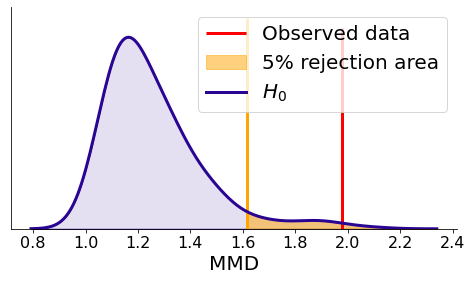

In [106]:
# 1000 simulated data sets from the well-specified model from training (for reference)

# Actual HNN simulation output (this should not be mispecified)

MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_HNN, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

## Five Actual HNN simulation outputs (this should not be mispecified)

In [107]:
def five_priors(seed=666):
    if seed is not None:
        np.random.seed(seed)
        
    random_array1 = np.random.uniform(0, 1, size=(5,))
    random_array2 = np.random.uniform(0, 1, size=(5,))
    random_array3 = np.random.uniform(0, 1, size=(5,))
    combined_array = np.vstack((random_array1, random_array2, random_array3))
    combined_array = np.squeeze(combined_array)
    return combined_array

In [108]:
five_params = five_priors()
five_params.shape

(3, 5)

In [109]:
five_data_HNN = simulator(params=five_params, n_obs=5)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEUR

In [110]:
five_data_HNN.shape

(5, 341)

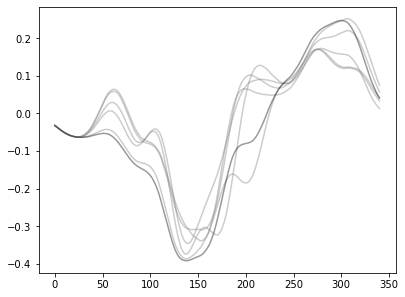

In [111]:
plt.plot(five_data_HNN.T, color='gray', alpha=0.4)
plt.plot(data_HNN.reshape(341,).T, color='black', alpha=0.4)

In [112]:
shape = five_data_HNN.shape
five_data_HNN = five_data_HNN.reshape(shape[0], 1, shape[1])
five_data_HNN.shape

(5, 1, 341)

In [113]:
observed_five_data_HNN = {}
observed_five_data_HNN['summary_conditions'] = five_data_HNN
observed_five_data_HNN['direct_conditions'] = None
observed_five_data_HNN['parameters'] = five_params.T

  0%|          | 0/500 [00:00<?, ?it/s]

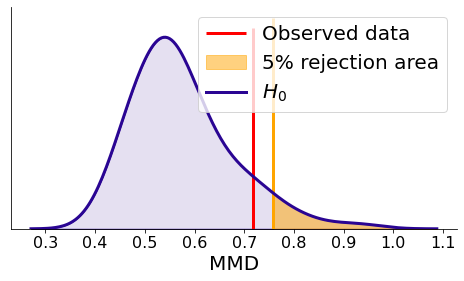

In [114]:
# 1000 simulated data sets from the well-specified model from training (for reference)

# Actual HNN simulation output (this should not be mispecified)

MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_five_data_HNN, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

## Flat line/constant values (should be mispecificied)

In [32]:
# all 0

data_flat0 = np.zeros(shape=(1,1,341))
observed_data_flat0 = {}
observed_data_flat0['summary_conditions'] = data_flat0
observed_data_flat0['direct_conditions'] = None
observed_data_flat0['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])

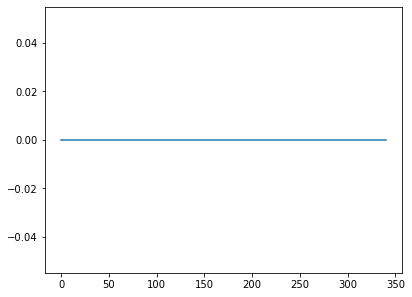

In [33]:
plt.plot(data_flat0.flatten().T)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

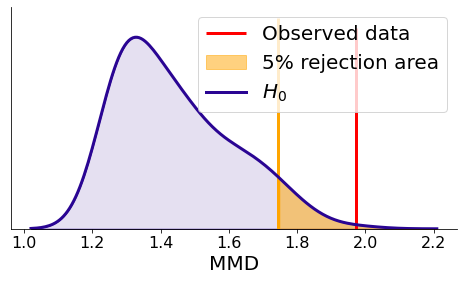

In [34]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_flat0, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

In [35]:
# all 0.015

data_flat = np.ones(shape=(1,1,341))*0.015
observed_data_flat = {}
observed_data_flat['summary_conditions'] = data_flat
observed_data_flat['direct_conditions'] = None
observed_data_flat['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])

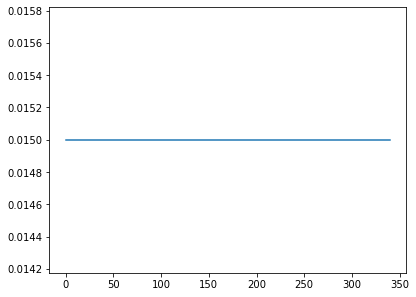

In [36]:
plt.plot(data_flat.flatten().T)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

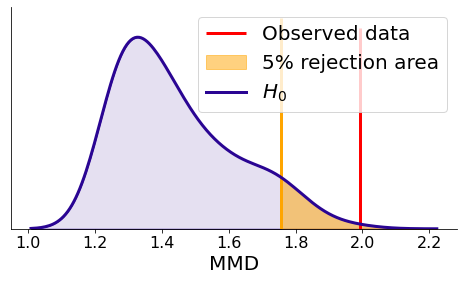

In [37]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_flat, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

In [38]:
# all 1

data_flat_2 = np.ones(shape=(1,1,341))
observed_data_flat_2 = {}
observed_data_flat_2['summary_conditions'] = data_flat_2
observed_data_flat_2['direct_conditions'] = None
observed_data_flat_2['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])

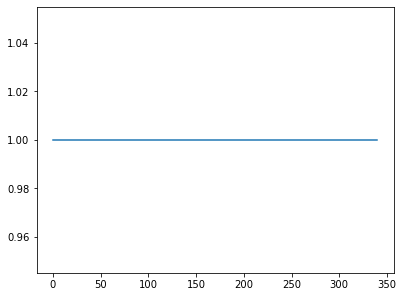

In [39]:
plt.plot(data_flat_2.flatten().T)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

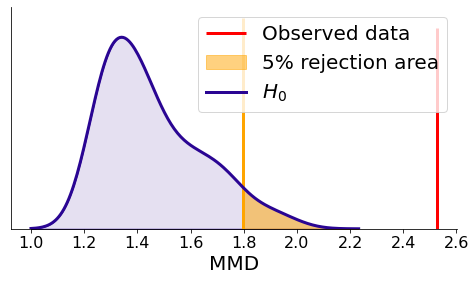

In [40]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_flat_2, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

## Flat line with gaussian noise (try different values of increasing noise amplitude)

In [41]:
# Gaussian noise

np.random.seed(666)

noise1 = np.random.normal(loc=0, scale=0, size=(341,))
noise2 = np.random.normal(loc=0, scale=0.001, size=(341,))
noise3 = np.random.normal(loc=0, scale=0.01, size=(341,)) #
noise4 = np.random.normal(loc=0, scale=0.1, size=(341,)) #
noise5 = np.random.normal(loc=0, scale=0.5, size=(341,)) #
noise6 = np.random.normal(loc=0, scale=1, size=(341,)) #
noise7 = np.random.normal(loc=0, scale=1.5, size=(341,)) #

noises = [noise1, noise2, noise3, noise4, noise5, noise6, noise7]
noise_names = ['noise_0', 'noise_0.001', 'noise_0.01', 'noise_0.1', 'noise_0.5', 'noise_1', 'noise_1.5']

noise_0


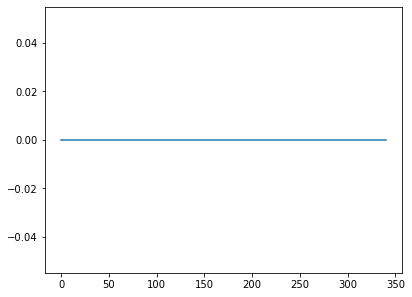

noise_0.001


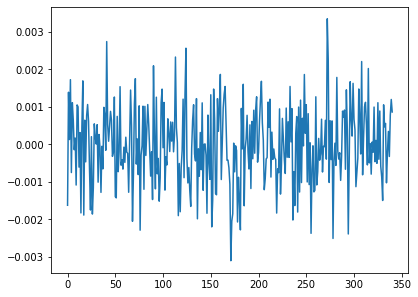

noise_0.01


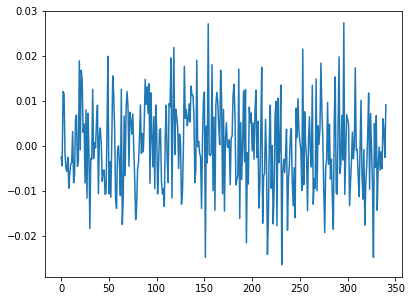

noise_0.1


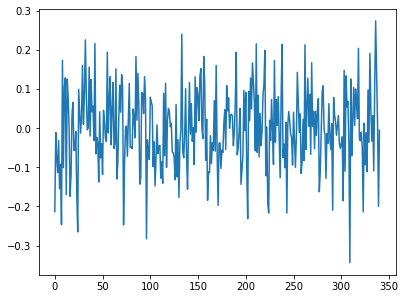

noise_0.5


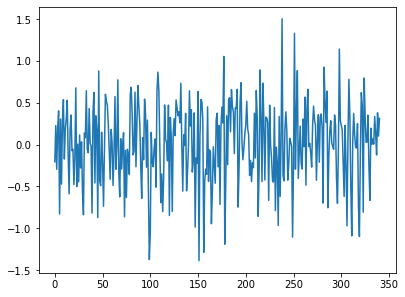

noise_1


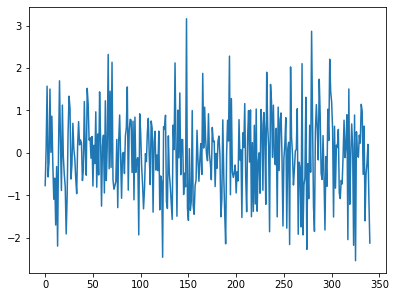

noise_1.5


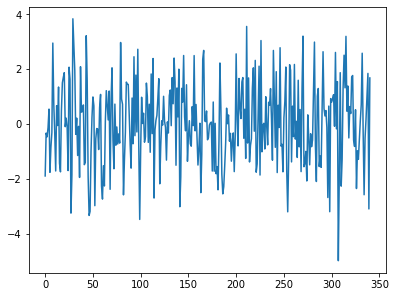

In [42]:
for noise, noise_name in zip(noises, noise_names):
    
    print(noise_name)
    
    data_flat_noise = data_flat0 + noise
    plt.plot(data_flat_noise.flatten().T)
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

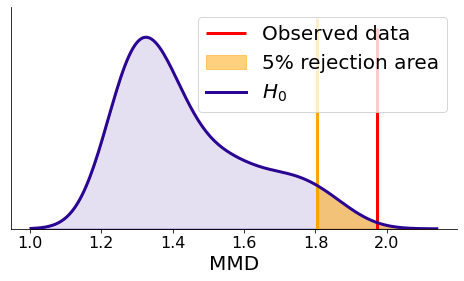

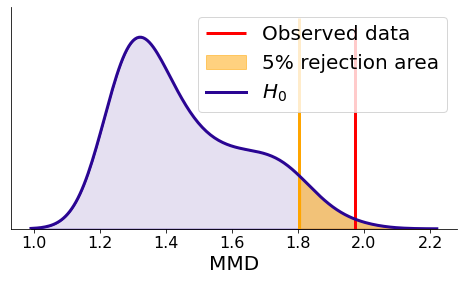

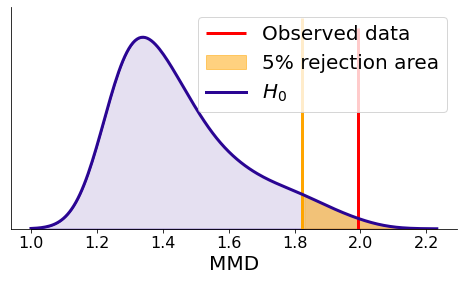

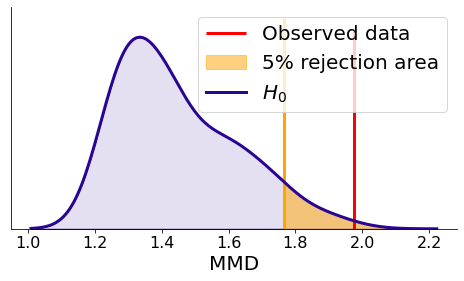

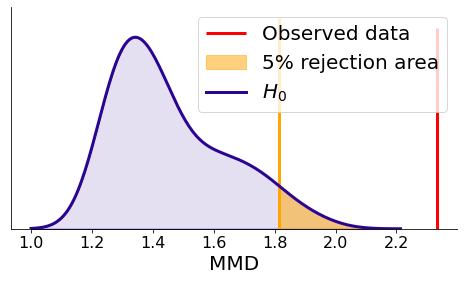

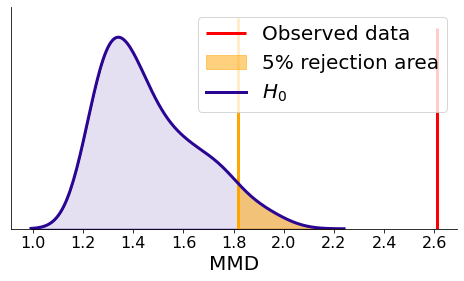

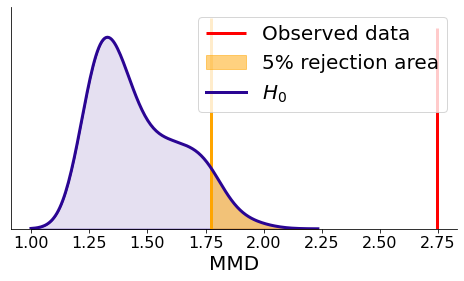

In [43]:
for noise, noise_name in zip(noises, noise_names):
    
    # print(noise_names)
    
    data_flat_noise = data_flat0 + noise
    # plt.plot(data_HNN_noise.flatten().T)
    # plt.show()
    
    observed_data_flat_noise = {}
    observed_data_flat_noise['summary_conditions'] = data_flat_noise
    observed_data_flat_noise['direct_conditions'] = None
    observed_data_flat_noise['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(observed_data_flat_noise, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True)
    _ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    

#     plt.savefig(f'hypothesis_test_figures/flat_zeros_data_with{noise_name}.png')
    # plt.close()

## One Actual HNN simulations with increasing noise

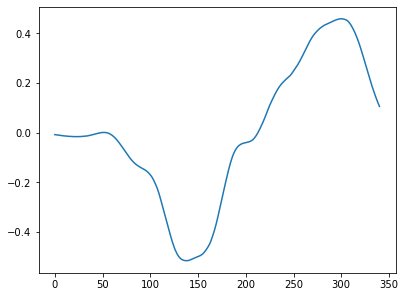

In [44]:
data_HNN_noise = data_HNN
plt.plot(data_HNN_noise.flatten().T)
plt.show()

In [45]:
# # Gaussian noise

# np.random.seed(666)

# noise1 = np.random.normal(loc=0, scale=0, size=(341,))
# noise2 = np.random.normal(loc=0, scale=0.05, size=(341,))
# noise3 = np.random.normal(loc=0, scale=0.1, size=(341,)) #
# noise4 = np.random.normal(loc=0, scale=0.2, size=(341,)) #
# noise5 = np.random.normal(loc=0, scale=0.3, size=(341,)) #
# noise6 = np.random.normal(loc=0, scale=0.5, size=(341,)) #
# noise7 = np.random.normal(loc=0, scale=1.0, size=(341,)) #

# noises = [noise1, noise2, noise3, noise4, noise5, noise6, noise7]
# noise_names = ['noise_0', 'noise_0.05', 'noise_0.1', 'noise_0.2', 'noise_0.3', 'noise_0.5', 'noise_1']

noise_0


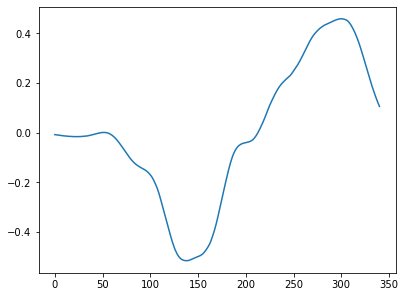

noise_0.001


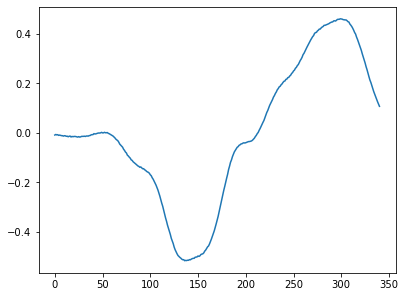

noise_0.01


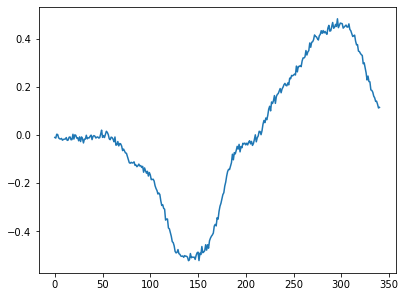

noise_0.1


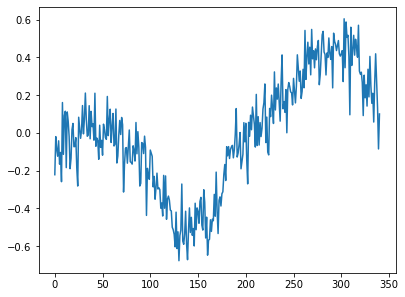

noise_0.5


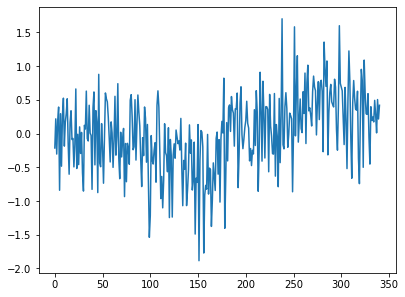

noise_1


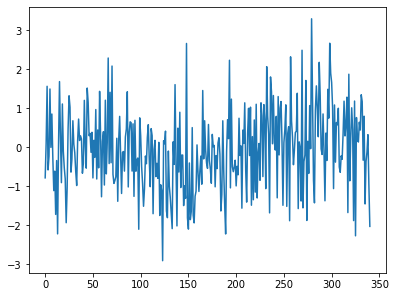

noise_1.5


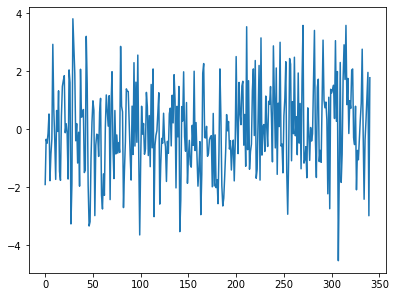

In [46]:
for noise, noise_name in zip(noises, noise_names):
    
    print(noise_name)
    
    data_HNN_noise = data_HNN + noise
    plt.plot(data_HNN_noise.flatten().T)
    plt.show()

noise_0


  0%|          | 0/500 [00:00<?, ?it/s]

noise_0.001


  0%|          | 0/500 [00:00<?, ?it/s]

noise_0.01


  0%|          | 0/500 [00:00<?, ?it/s]

noise_0.1


  0%|          | 0/500 [00:00<?, ?it/s]

noise_0.5


  0%|          | 0/500 [00:00<?, ?it/s]

noise_1


  0%|          | 0/500 [00:00<?, ?it/s]

noise_1.5


  0%|          | 0/500 [00:00<?, ?it/s]

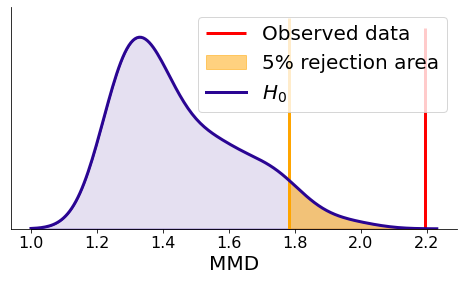

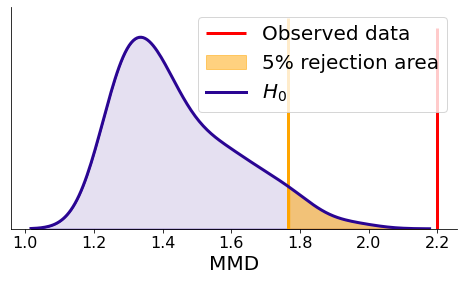

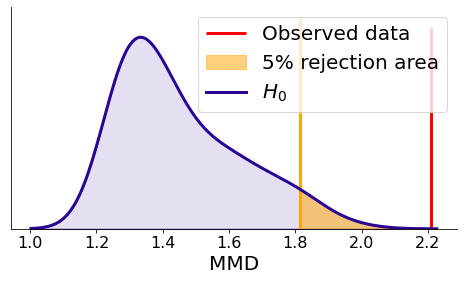

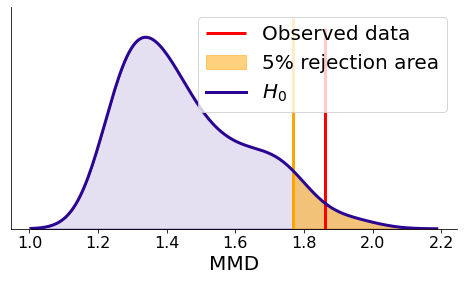

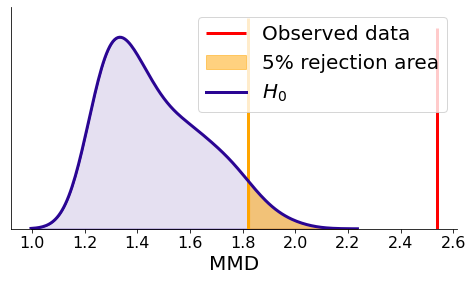

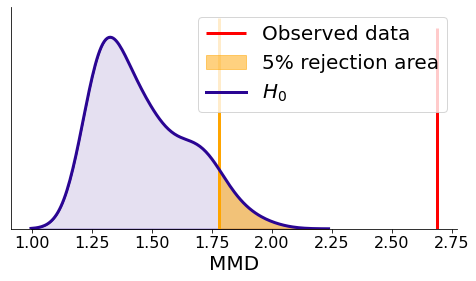

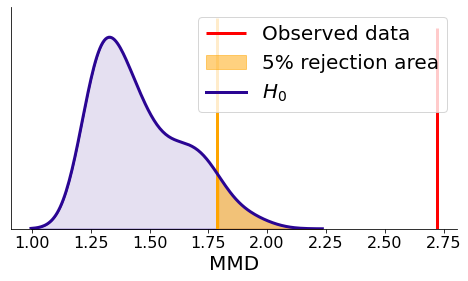

In [47]:
for noise, noise_name in zip(noises, noise_names):
    
    print(noise_name)
    
    data_HNN_noise = data_HNN + noise
    # plt.plot(data_HNN_noise.flatten().T)
    # plt.show()
    
    observed_data_HNN_noise = {}
    observed_data_HNN_noise['summary_conditions'] = data_HNN_noise
    observed_data_HNN_noise['direct_conditions'] = None
    observed_data_HNN_noise['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])
    
    MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(observed_data_HNN_noise, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True)
    _ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)
    

#     plt.savefig(f'hypothesis_test_figures/real_obv_with{noise_name}.png')
    # plt.close()

## Real ERP data from HNN-GUI example

In [115]:
# 1000 simulated data

ori_x = torch.load('Aug15_data1000_3ERPDrives_no_preprocessing/x.pt')
ori_theta = torch.load('Aug15_data1000_3ERPDrives_no_preprocessing/theta.pt')

In [116]:
ori_x = np.array(ori_x)
ori_theta = np.array(ori_theta)

In [117]:
ori_x.shape

(1000, 341)

In [118]:
# Preprocess the 1000 simulated data

# Center time series by taking the “grand mean” (mean of all entries in matrix) and subtract from each row
avg = np.mean(ori_x)
ori_x = ori_x - avg

# Divide entire matrix by maximum of absolute value
maxAbs = np.max(np.abs(ori_x))
ori_x = ori_x / maxAbs

# # Smoothing
for i in range(len(ori_x)):
    ori_x[i] = smooth_waveform(ori_x[i], window_len=30, sfreq=1000.0 / 0.5)

In [119]:
avg_x = np.mean(ori_x, axis=0)
avg_x.shape

(341,)

In [120]:
# Real ERP data from HNN-GUI example

yes_data = torch.load('Real_ERP_data/np_yes_data.pt')
no_data = torch.load('Real_ERP_data/np_no_data.pt')

In [121]:
# Preprocess the real ERP data from HNN-GUI example

# Divide the experimental data by the scaling factor
yes_data = yes_data / 3000
no_data = no_data / 3000

# Center time series by taking the “grand mean” (mean of all entries in matrix) and subtract from each row
yes_data = yes_data - avg
no_data = no_data - avg

# Divide entire matrix by maximum of absolute value
yes_data = yes_data / maxAbs
no_data = no_data / maxAbs

# # Smoothing
# for i in range(len(ori_x)):
#     ori_x[i] = smooth_waveform(ori_x[i], window_len=30, sfreq=1000.0 / 0.5)

In [122]:
yes_data.shape

(341,)

In [123]:
yes_data_reshaped = yes_data.reshape(1, 1, 341)
no_data_reshaped = no_data.reshape(1, 1, 341)

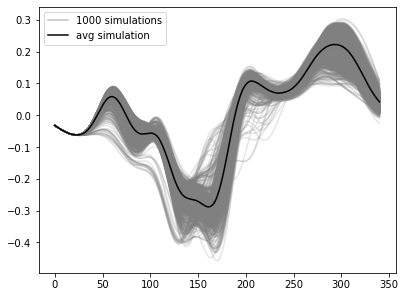

In [124]:
plt.plot(ori_x.T, color='gray', alpha=0.2)
plt.plot([], color='gray', alpha=0.5, label='1000 simulations')  #just for legend setting purpose
plt.plot(avg_x.T, color='black', label="avg simulation")
# plt.plot(yes_data.T, color='red', label="yes_trial_S1_ERP_all_avg")
# plt.plot(no_data.T, color='blue', label="no_trial_S1_ERP_all_avg")
plt.legend()
plt.show()

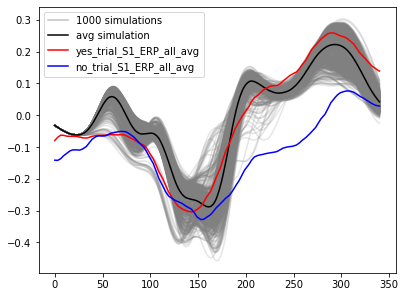

In [125]:
plt.plot(ori_x.T, color='gray', alpha=0.2)
plt.plot([], color='gray', alpha=0.5, label='1000 simulations')  #just for legend setting purpose
plt.plot(avg_x.T, color='black', label="avg simulation")
plt.plot(yes_data.T, color='red', label="yes_trial_S1_ERP_all_avg")
plt.plot(no_data.T, color='blue', label="no_trial_S1_ERP_all_avg")
plt.legend()
plt.show()

In [126]:
# yes_trial_S1_ERP_all_avg.txt
data_ERP_yes = yes_data_reshaped
observed_data_ERP_yes = {}
observed_data_ERP_yes['summary_conditions'] = data_ERP_yes
observed_data_ERP_yes['direct_conditions'] = None
# observed_data_ERP_yes['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])
# observed_data_ERP_yes['parameters'] = None

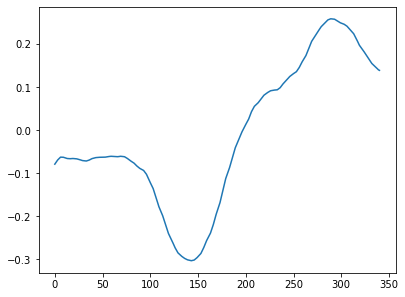

In [127]:
plt.plot(data_ERP_yes.flatten().T)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

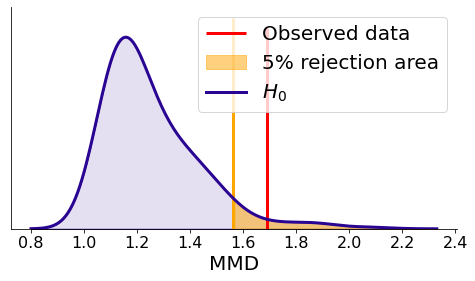

In [128]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_ERP_yes, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

In [129]:
# no_trial_S1_ERP_all_avg.txt
data_ERP_no = no_data_reshaped
observed_data_ERP_no = {}
observed_data_ERP_no['summary_conditions'] = data_ERP_no
observed_data_ERP_no['direct_conditions'] = None
# observed_data_ERP_no['parameters'] = np.array([[0.142300 , 0.00865, 0.684013]])
# observed_data_ERP_no['parameters'] = None

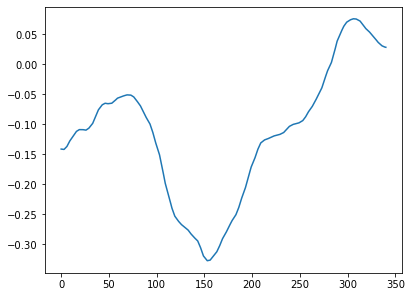

In [130]:
plt.plot(data_ERP_no.flatten().T)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

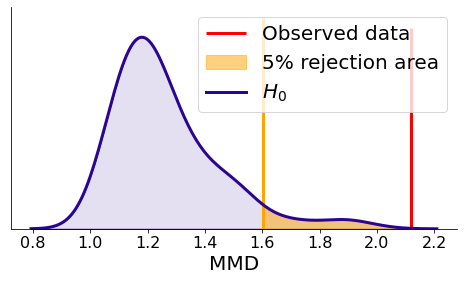

In [131]:
MMD_sampling_distribution, MMD_observed = trainer.mmd_hypothesis_test(
    observed_data_ERP_no, reference_data=reference_data, num_reference_simulations=1000, num_null_samples=500, bootstrap=True
)
_ = bf.diagnostics.plot_mmd_hypothesis_test(MMD_sampling_distribution, MMD_observed)

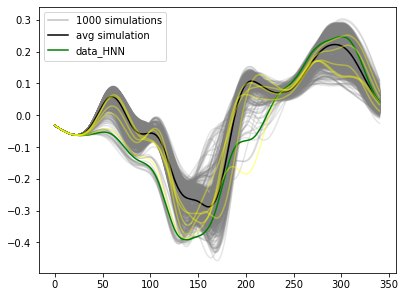

In [133]:
plt.plot(ori_x.T, color='gray', alpha=0.2)
plt.plot([], color='gray', alpha=0.5, label='1000 simulations')  #just for legend setting purpose
plt.plot(avg_x.T, color='black', label="avg simulation")
# plt.plot(yes_data.T, color='red', label="yes_trial_S1_ERP_all_avg")
# plt.plot(no_data.T, color='blue', label="no_trial_S1_ERP_all_avg")
plt.plot(data_HNN.flatten().T, color='green', label="data_HNN")
plt.plot(five_data_HNN.reshape(5,341).T, color='yellow', alpha=0.4)
plt.legend()
plt.show()